In this file, we detect the switching pts without rank deduction. 

For CPD, we sum the Amat for each subject and

do orthogonalization for both B1 (U) and B2 (V).

And here I use both AD and ctrl to get the U and V

In [1]:
import scipy
import mat73
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.io import loadmat
from tqdm import trange, tqdm
from functools import partial
from pprint import pprint

from collections import defaultdict as ddict
from easydict import EasyDict as edict


%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT, FIG_ROOT

plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
# gtvdn
import gtvdn.gtvdn_det_CPD
importlib.reload(gtvdn.gtvdn_det_CPD)
from gtvdn.gtvdn_det_CPD import screening_4CPD, dyna_prog_4CPD

import gtvdn.gtvdn_post
importlib.reload(gtvdn.gtvdn_post)
from gtvdn.gtvdn_post import update_kp

import gtvdn.gtvdn_pre
importlib.reload(gtvdn.gtvdn_pre)
from gtvdn.gtvdn_pre import preprocess_MEG

import gtvdn.gtvdn_utils
importlib.reload(gtvdn.gtvdn_utils)
from gtvdn.gtvdn_utils import get_bspline_est , get_newdata, get_Amats, get_Nlogk

In [4]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl_dict2folder, load_pkl_folder2dict

import utils.projection
importlib.reload(utils.projection)
from utils.projection import euclidean_proj_l1ball

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn

import utils.tensor
importlib.reload(utils.tensor)
from utils.tensor import decompose_three_way_orth, sort_orthCPD, decompose_three_way_fix

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Some fns

In [5]:
# truncate small value in vec
def _cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [6]:
# plot the corrmat with 7 canonical nets
def _corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                xticklabels=np.arange(1, vecs.shape[-1]+1),
                cmap="bwr", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

## Set parameters

In [7]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012012

In [8]:
# in case you want to update any parameters
paras.keys()
paras.res_dir = RES_ROOT

In [9]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method8"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Save to {_paras.save_dir}")
if not _paras.save_dir.exists():
    _paras.save_dir.mkdir()

Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8


In [10]:
# load results
cur_res = load_pkl_folder2dict(_paras.save_dir)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ADs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs_selected.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyRe

## Load data

In [11]:
datFil = list(DATA_ROOT.glob("70Ctrl*"))[0]
CtrlDat1 = loadmat(datFil)
CtrlDats = CtrlDat1["dk10"]

In [12]:
datFil = list(DATA_ROOT.glob("87AD*"))[0]
ADDat1 = loadmat(datFil)
ADDats = ADDat1["dk10"]

In [13]:
ADdatAdd = loadmat(DATA_ROOT/"DK_timecourse.mat")["DK_timecourse"]

In [14]:
CtrldatAdd = mat73.loadmat(DATA_ROOT/"timecourse_ucsfCONT_group.mat")["dk10"]

In [15]:
baseDF = pd.read_csv(DATA_ROOT/"AllDataBaselineOrdered.csv")
CtrlKp = np.array(baseDF[baseDF["Grp"]=="Ctrl"]["KeepIt"] == 1)

In [16]:
ADDatsAll = np.concatenate([ADDats, ADdatAdd[np.newaxis, :, :]], axis=0)
CtrlDatsAll = np.concatenate([CtrlDats, CtrldatAdd], axis=0)
CtrlDatsAll = CtrlDatsAll[CtrlKp]

In [17]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

## Run 

### Bspline smooth

In [18]:
Ymat_ctrl = preprocess_MEG(CtrlDatsAll[:], paras)
Ymat_AD = preprocess_MEG(ADDatsAll[:], paras)

In [19]:
time_span = np.linspace(0, paras.T, Ymat_AD.shape[-1])

if not ("dXXmats_AD" in cur_res.keys()):
    dXmats_AD, Xmats_AD = get_bspline_est(Ymat_AD, time_span, paras.lamb)
    dXmats_ctrl, Xmats_ctrl = get_bspline_est(Ymat_ctrl, time_span, paras.lamb)
    cur_res.dXXmats_AD = [dXmats_AD, Xmats_AD]
    cur_res.dXXmats_ctrl = [dXmats_ctrl, Xmats_ctrl]
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

#plt.figure(figsize=[10, 5])
#plt.subplot(121)
#for ix in range(68):
#    plt.plot(Xmats_AD[0, ix, :])
#plt.subplot(122)
#for ix in range(68):
#    plt.plot(Xmats_ctrl[0, ix, :])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:29<00:00,  2.99it/s]


/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ctrls.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../resul

### Estimate Amats

In [20]:
if not ("Amats_AD" in cur_res.keys()):
    Amats_ADs_lowrank = get_Amats(dXmats_AD[:], Xmats_AD[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    cur_res.Amats_AD = Amats_ADs_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

In [21]:
if not ("Amats_ctrl" in cur_res.keys()):
    Amats_ctrls_lowrank = get_Amats(dXmats_ctrl[:], Xmats_ctrl[:], time_span, downrate=paras.downsample_rate, 
                              fct=paras.fct, nRks=paras.num_ranks, is_stack=False)
    cur_res.Amats_ctrl = Amats_ctrls_lowrank
    save_pkl_dict2folder(RES_ROOT/_paras.folder_name, cur_res)

### rank-R CP decomposition

In [22]:
cur_res.keys()

dict_keys(['Amats_AD', 'Amats_ctrl', 'CPDresult', 'can_pts_ADs', 'can_pts_ctrls', 'cpts_ADs', 'cpts_ADs_selected', 'cpts_ctrls', 'cpts_ctrls_selected', 'dwells_ADs_selected', 'dwells_ctrls_selected', 'post_paras', 'rank_ADs', 'rank_ctrls', 'singular_vals_ADs', 'singular_vals_ctrls', 'dXXmats_AD', 'dXXmats_ctrl'])

In [23]:
# transform to tensor
tensors_ctrl = np.transpose(np.array(cur_res.Amats_ctrl), (1, 2, 0))
tensors_AD = np.transpose(np.array(cur_res.Amats_AD), (1, 2, 0))
tensors_both = np.concatenate([tensors_ctrl, tensors_AD],axis=-1)

# the initial value 
Amat_both_lowrank = np.sum(tensors_both, axis=-1)
U, _, VT = np.linalg.svd(Amat_both_lowrank)
both_CPD_init = [U[:, :paras.r], VT.T[:, :paras.r]]

In [24]:
# rank-R decomposition
if not ("CPDresult" in cur_res.keys()):
    CPDresult = sort_orthCPD(decompose_three_way_orth(tensors_both, 
                                                      paras.r, 
                                                      init=both_CPD_init, 
                                                      eps=1e-10, 
                                                      is_fixU=False,
                                                      verbose=True))
    cur_res.CPDresult = CPDresult
    save_pkl_dict2folder(_paras.save_dir, cur_res)

### Save U

In [11]:
from constants import REGION_NAMES, REGION_NAMES_WLOBE
from utils.standardize import minmax, minmax_mat, minmax_plotting
from utils.brain_plot import reorder_U, U_2brain_vec, obt_FC_exp
from utils.misc import spec_emb_red

# save the files for brainplotting
def save_brainplotting_vec(vecs, filname_prefix, order=2, is_csv=False):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    for ix in range(vecs.shape[1]):
        cur_sing_vec = vecs[:, ix]
        out_vec_raw = minmax_plotting(cur_sing_vec, order=order)
        out_vec = U_2brain_vec(reorder_U(out_vec_raw))
        np.savetxt(paras.res_dir/f"./{filname_prefix}_{ix+1}.txt", out_vec)
        if is_csv:
            pd.DataFrame({"Name": REGION_NAMES,
                      "Vec": cur_sing_vec}).to_csv(paras.res_dir/f"./{filname_prefix}_{ix+1}.csv",
                                                          index=False)

In [16]:
U = cur_res.CPDresult[0]
V = cur_res.CPDresult[1]
com_Us = []
for ix in range(20):
    curU, curV = U[:, ix], V[:, ix]
    both_info = np.stack([curU, curV]).T
    com_U = spec_emb_red(both_info)
    com_Us.append(np.squeeze(com_U))
cur_res.com_Us = np.array(com_Us).T

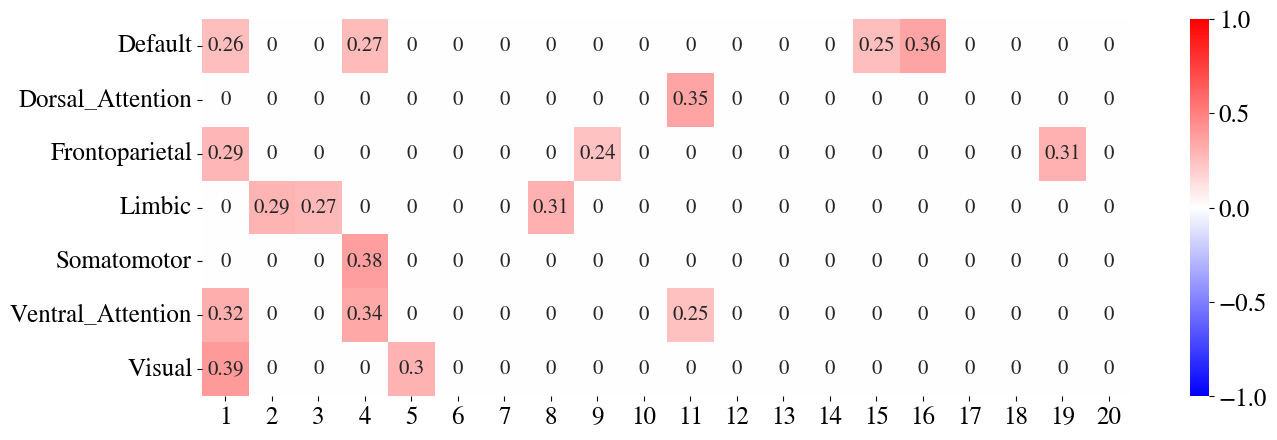

In [22]:
tfn1 = partial(_cumsum_trunc, cutoff=1.90)
corr_mat = _corr_plot(cur_res.com_Us, cutoff=0.05, trun_fn=tfn1, trans_fn=lambda x:np.abs(x));

<AxesSubplot:>

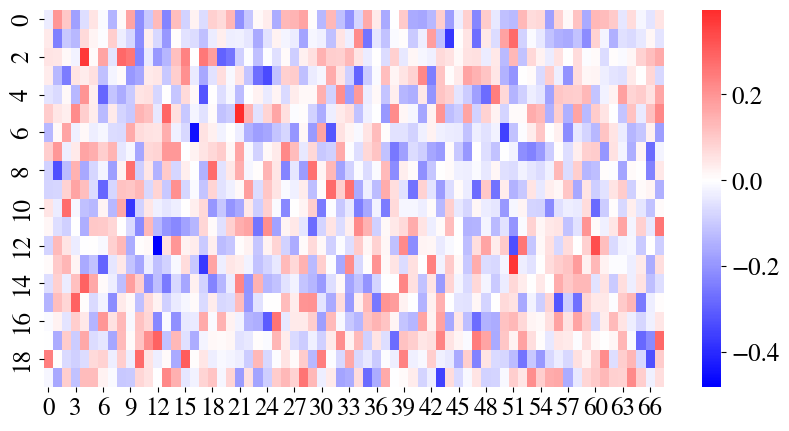

In [25]:
plt.figure(figsize=[10, 5])
sns.heatmap(U.T, center=0, cmap="bwr")
#sns.heatmap(cur_res.com_Us.T, center=0, cmap="bwr")

In [31]:
save_brainplotting_vec(np.abs(cur_res.com_Us), "m8_abs_comU_order3", 3)
save_brainplotting_vec(cur_res.com_Us, "m8_raw_comU_order3", 3)

In [32]:
save_brainplotting_vec(np.abs(V), "m8_abs_V_order3", 3)
save_brainplotting_vec(V, "m8_raw_V_order3", 3)

### Reduce the dim of the data

In [25]:
nXmats_ctrl =  np.matmul(cur_res.CPDresult[1].T[np.newaxis, :, :],
                         cur_res.dXXmats_ctrl[1])
nXmats_AD =  np.matmul(cur_res.CPDresult[1].T[np.newaxis, :, :], 
                       cur_res.dXXmats_AD[1])

ndXmats_ctrl =  np.matmul(cur_res.CPDresult[0].T[np.newaxis, :, :], 
                          cur_res.dXXmats_ctrl[0])
ndXmats_AD =  np.matmul(cur_res.CPDresult[0].T[np.newaxis, :, :], 
                        cur_res.dXXmats_AD[0])

In [26]:
if not ("nXmats_ctrl" in cur_res.keys()):
    cur_res.nXmats_ctrl = nXmats_ctrl
    save_pkl_dict2folder(_paras.save_dir, cur_res)
    
if not ("nXmats_AD" in cur_res.keys()):
    cur_res.nXmats_AD = nXmats_AD
    save_pkl_dict2folder(_paras.save_dir, cur_res)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ctrls.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../resul

In [27]:
if not ("ndXmats_ctrl" in cur_res.keys()):
    cur_res.ndXmats_ctrl = ndXmats_ctrl
    save_pkl_dict2folder(_paras.save_dir, cur_res)
    
if not ("ndXmats_AD" in cur_res.keys()):
    cur_res.ndXmats_AD = ndXmats_AD
    save_pkl_dict2folder(_paras.save_dir, cur_res)

/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_AD.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/can_pts_ctrls.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl exists! Use is_force=True to save it anyway
/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method8/../../mypkg/../resul

### Screening

In [29]:
if not ("can_pts_ctrls" in cur_res.keys()):
    can_pts_ctrls = screening_4CPD(cur_res.ndXmats_ctrl, cur_res.nXmats_ctrl, wh=paras.wh)
    cur_res.can_pts_ctrls = can_pts_ctrls
    save_pkl_dict2folder(_paras.save_dir, cur_res)

Screening: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [06:35<00:00,  4.50s/it]

/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/CPDresult.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/ndXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results

In [30]:
if not ("can_pts_ADs" in cur_res.keys()):
    can_pts_ADs = screening_4CPD(cur_res.ndXmats_AD, cur_res.nXmats_AD, wh=paras.wh)
    cur_res.can_pts_ADs = can_pts_ADs
    save_pkl_dict2folder(_paras.save_dir, cur_res)

Screening: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [06:36<00:00,  4.50s/it]

/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/CPDresult.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/ndXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results

### Detection

In [31]:
if not ("cpts_ctrls" in cur_res.keys()):
    cpts_ctrls = []
    for ix in trange(len(cur_res.can_pts_ctrls)):
        res = dyna_prog_4CPD(cur_res.ndXmats_ctrl[ix], 
                             cur_res.nXmats_ctrl[ix], 
                             paras.kappa, 
                             Lmin=paras.Lmin,  
                             canpts=cur_res.can_pts_ctrls[ix], 
                             maxM=paras.maxM,  
                             is_full=True,  
                             showProgress=False)
        cpts_ctrls.append(res)
    
    cur_res.cpts_ctrls = cpts_ctrls
    save_pkl_dict2folder(_paras.save_dir, cur_res)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [14:47<00:00, 10.09s/it]

/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/CPDresult.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/ndXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results

In [32]:
if not ("cpts_ADs" in cur_res.keys()):
    cpts_ADs = []
    for ix in trange(len(cur_res.can_pts_ADs)):
        res = dyna_prog_4CPD(cur_res.ndXmats_AD[ix], 
                             cur_res.nXmats_AD[ix], 
                             paras.kappa, 
                             Lmin=paras.Lmin,  
                             canpts=cur_res.can_pts_ADs[ix], 
                             maxM=paras.maxM,  
                             is_full=True,  
                             showProgress=False)
        cpts_ADs.append(res)
    
    cur_res.cpts_ADs = cpts_ADs
    save_pkl_dict2folder(_paras.save_dir, cur_res)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [15:31<00:00, 10.58s/it]

/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/dXXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/Amats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/CPDresult.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/nXmats_AD.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results/method8_r10/ndXmats_ctrl.pkl exists! Use is_force=True to save it anyway
/gTVDN/notebooks/method8/../../mypkg/../results